# Implement this analysis in the Vorticity field 4 EKE.

Try removing the ssha contour from this velocity field and the other one.

In [1]:
# Importing all libraries.
from pylab import *
from netCDF4 import Dataset
%matplotlib inline
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
from trackeddy.plotfunc import *
import seawater as sw

In [37]:
# Output data path
outputpath='/g/data/v45/akm157/model_output/mom/mom01v5_kds75/output306/'
# Import velocity fields values to python environment.

ncfile=Dataset(outputpath+'rregionsouthern_ocean_daily_eta_t.nc')
ssh=ncfile.variables['eta_t'][0,:,:]
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['xt_ocean_sub01'][:]
lat=ncfile.variables['yt_ocean_sub01'][:]

In [38]:
#Area in indexes, probably in the future it will be added an option for lon - lat coords.
areamap=array([[0,len(lon)],[0,len(lat)]])
mask=ma.getmask(ssh[:,:])


In [39]:
# Import SSH 10 yrs mean values to python environment.
ncfile=Dataset('/home/156/jm5970/notebooks/traceddy/data.output/meanssh_10yrs_AEXP.nc')
ssh_mean=squeeze(ncfile.variables['SSH_mean'][:]/100)
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['Longitude'][:]
lat=ncfile.variables['Latitude'][:]

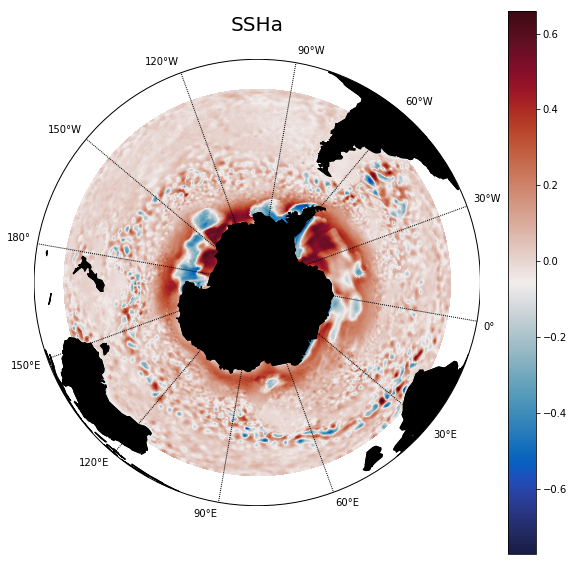

In [40]:
basemap_mplot(lon,lat,ssh-ssh_mean,title="SSHa",scale='Lin',cmap=cm.cm.balance,\
              vmin='',vmax='',xan=1,yan=1,figsize=(10,10),fontsize=20);
colorbar()

# Check this calculation

Geostrophic velocities:

$$u=-\frac{g}{f}\frac{d\eta}{dy}$$
$$v=\frac{g}{f}\frac{d\eta}{dx}$$

In [77]:
def geovelfield(ssha,lon,lat):
    distmlon=sw.dist(0,lon,'km')[0][:]*1000
    distmlat=sw.dist(0,lat,'km')[0][:]*1000
    mlon=cumsum(distmlon)
    mlat=cumsum(distmlat)
    dy=gradient(mlat)
    dx=gradient(mlon)
    print(shape(ssha))
    detay,detax=gradient(ssha)
    omega = 7.2921e-5
    g=9.81
    f=2*omega*sin(np.deg2rad(lat))
    u=zeros(shape(ssh))
    v=zeros(shape(ssh))
    for ii in range(shape(ssh)[1]-1):
        detaxdy=detax[:,ii]/dx[ii]
        v[:,ii]=(g/f)*(detaxdy)
    for jj in range(shape(ssh)[0]-1):
        detaydx=detay[jj,:]/dy[jj]
        u[jj,:]=-(g/f[jj])*(detaydx)
    u[u>1000]=0
    v[v>1000]=0
    u[u<-1000]=0
    v[v<-1000]=0
    return u,v

u_g,v_g=geovelfield(ssh,lon,lat)
u_g=np.ma.masked_array(u_g, mask)
v_g=np.ma.masked_array(v_g, mask)
print(u_g.max())

(931, 3600)
849.149414062


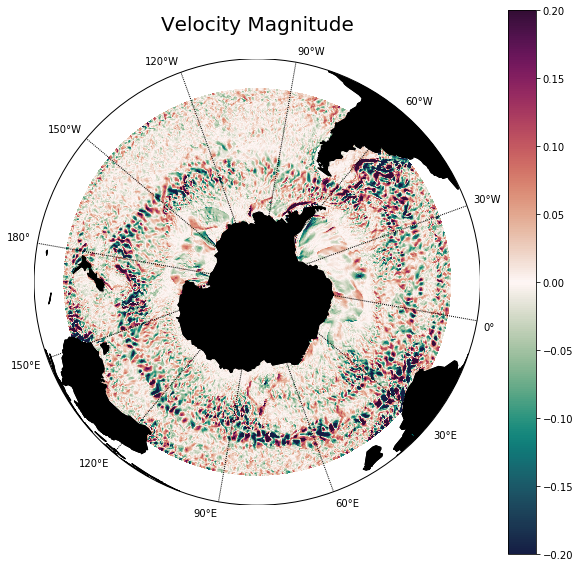

In [78]:
basemap_mplot(lon,lat,v_g,title="Velocity Magnitude",scale='Lin',cmap=cm.cm.curl,\
              vmin=-0.2,vmax=0.2,xan=1,yan=1,figsize=(10,10),fontsize=20);
colorbar()

In [79]:
def vorticity2D(u,v):
    dv_x=np.gradient(v[:,:],axis=1)
    du_y=np.gradient(u[:,:],axis=0)
    w=dv_x-du_y
    return w

w=vorticity2D(u_g,v_g)

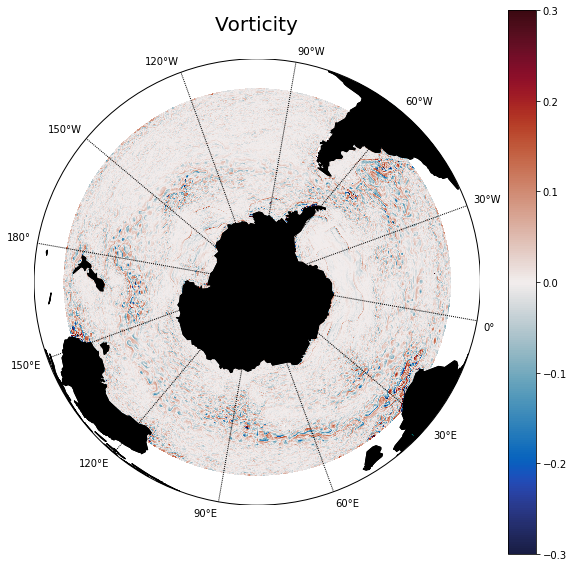

In [85]:
basemap_mplot(lon,lat,w,title="Vorticity",scale='Lin',cmap=cm.cm.balance,\
              vmin=-0.3,vmax=0.3,xan=1,yan=1,figsize=(10,10),fontsize=20);
colorbar()
# EkE=0.5 * (u_avg**2 + v_avg**2)

In [84]:
eddytd=analyseddyzt(w,lon,lat,0,1,1,0.4,0.1,0.1,data_meant='',areamap=areamap,mask=''\
                     ,destdir='',okparm='',diagnostics=False,pprint=False)

If you whant to analyze in time the data need to be 3d [i.e. data(t,x,y)]
Be sure the data is an anomaly
 0% [>]100% Time Elapsed: 14 s  

In [86]:
threshold=1
eddysplot=exeddy(eddytd,lat,lon,w,0,threshold,diagnostics=False)

*******Removing of eddies******
*******End the Removing of eddies******


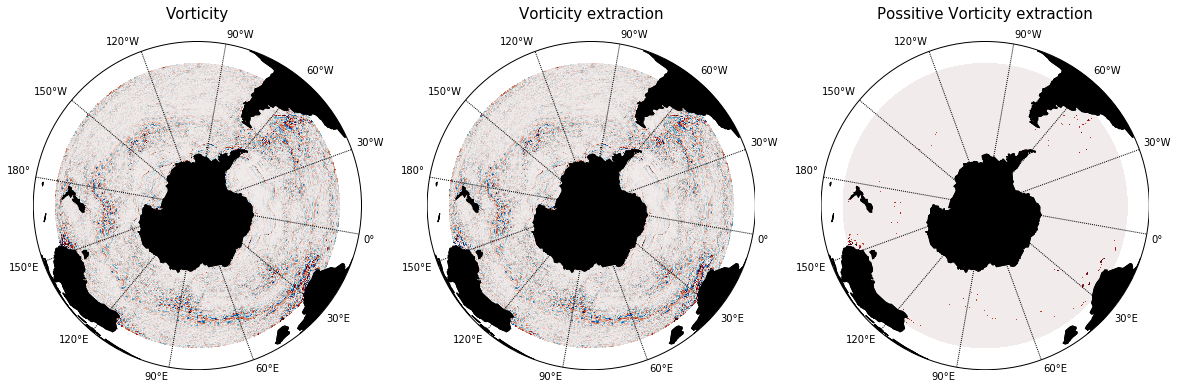

In [87]:
basemap_mplot(lon,lat,[w,w-eddysplot,eddysplot]\
              ,title=["Vorticity","Vorticity extraction","Possitive Vorticity extraction"],scale='Lin',\
              cmap=cm.cm.balance,vmin=-0.2,vmax=0.2,xan=1,yan=3,figsize=(20,20),fontsize=15);

In [88]:
eddytdn=analyseddyzt(w,lon,lat,0,1,1,-0.4,-0.1,-0.1,data_meant='',areamap=areamap,mask=''\
                     ,destdir='',okparm='',diagnostics=False,pprint=False)

If you whant to analyze in time the data need to be 3d [i.e. data(t,x,y)]
Be sure the data is an anomaly
 0% [>]100% Time Elapsed: 18 s  

In [89]:
threshold=1
eddysplotn=exeddy(eddytdn,lat,lon,w,0,threshold,diagnostics=False)

*******Removing of eddies******
*******End the Removing of eddies******


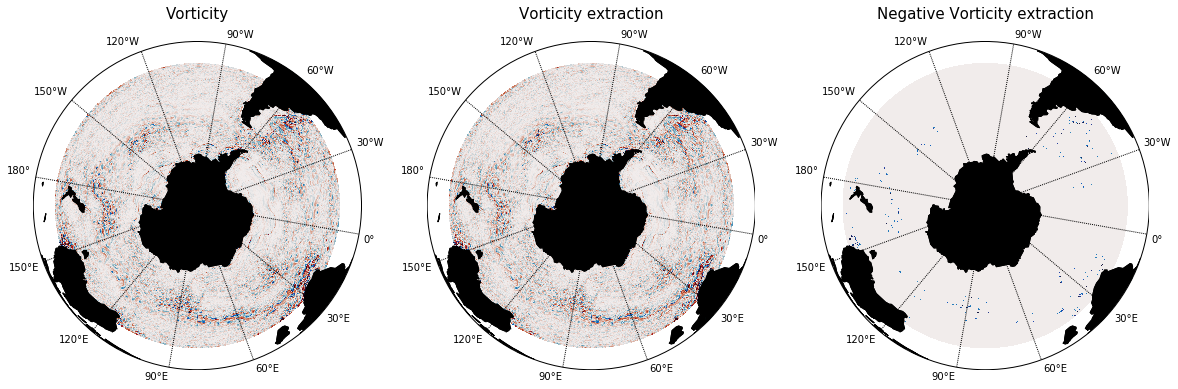

In [90]:
basemap_mplot(lon,lat,[w,w-eddysplotn,eddysplotn]\
              ,title=["Vorticity","Vorticity extraction","Negative Vorticity extraction"],scale='Lin',cmap=cm.cm.balance,\
              vmin=-0.2,vmax=0.2,xan=1,yan=3,figsize=(20,20),fontsize=15);

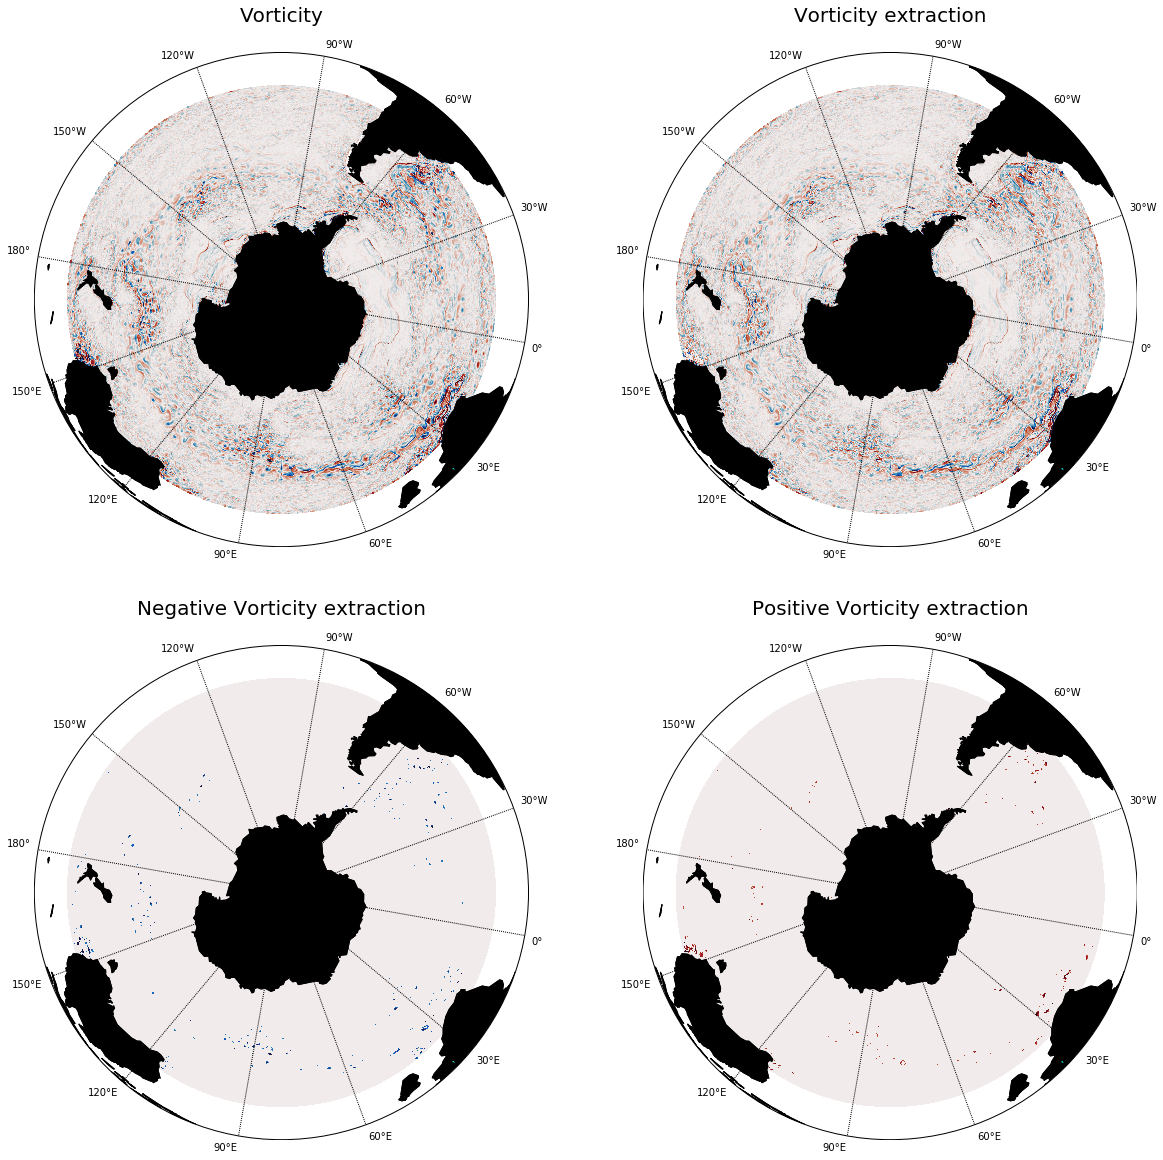

In [91]:
basemap_mplot(lon,lat,[w,w-eddysplot-eddysplotn,eddysplotn,eddysplot]\
              ,title=["Vorticity","Vorticity extraction","Negative Vorticity extraction",\
                       "Positive Vorticity extraction"],scale='Lin',cmap=cm.cm.balance,\
              vmin=-0.2,vmax=0.2,xan=2,yan=2,figsize=(20,20),fontsize=20);

In [92]:
threshold=3
eddysup=exeddy(eddytd,lat,lon,u_g,0,threshold,inside=w,diagnostics=False)
eddysun=exeddy(eddytdn,lat,lon,u_g,0,threshold,inside=w,diagnostics=False)

*******Removing of eddies******
*******End the Removing of eddies******
*******Removing of eddies******
*******End the Removing of eddies******


In [93]:
threshold=3
eddysvp=exeddy(eddytd,lat,lon,v_g,0,threshold,inside=w,diagnostics=False)
eddysvn=exeddy(eddytdn,lat,lon,v_g,0,threshold,inside=w,diagnostics=False)

*******Removing of eddies******
*******End the Removing of eddies******
*******Removing of eddies******
*******End the Removing of eddies******


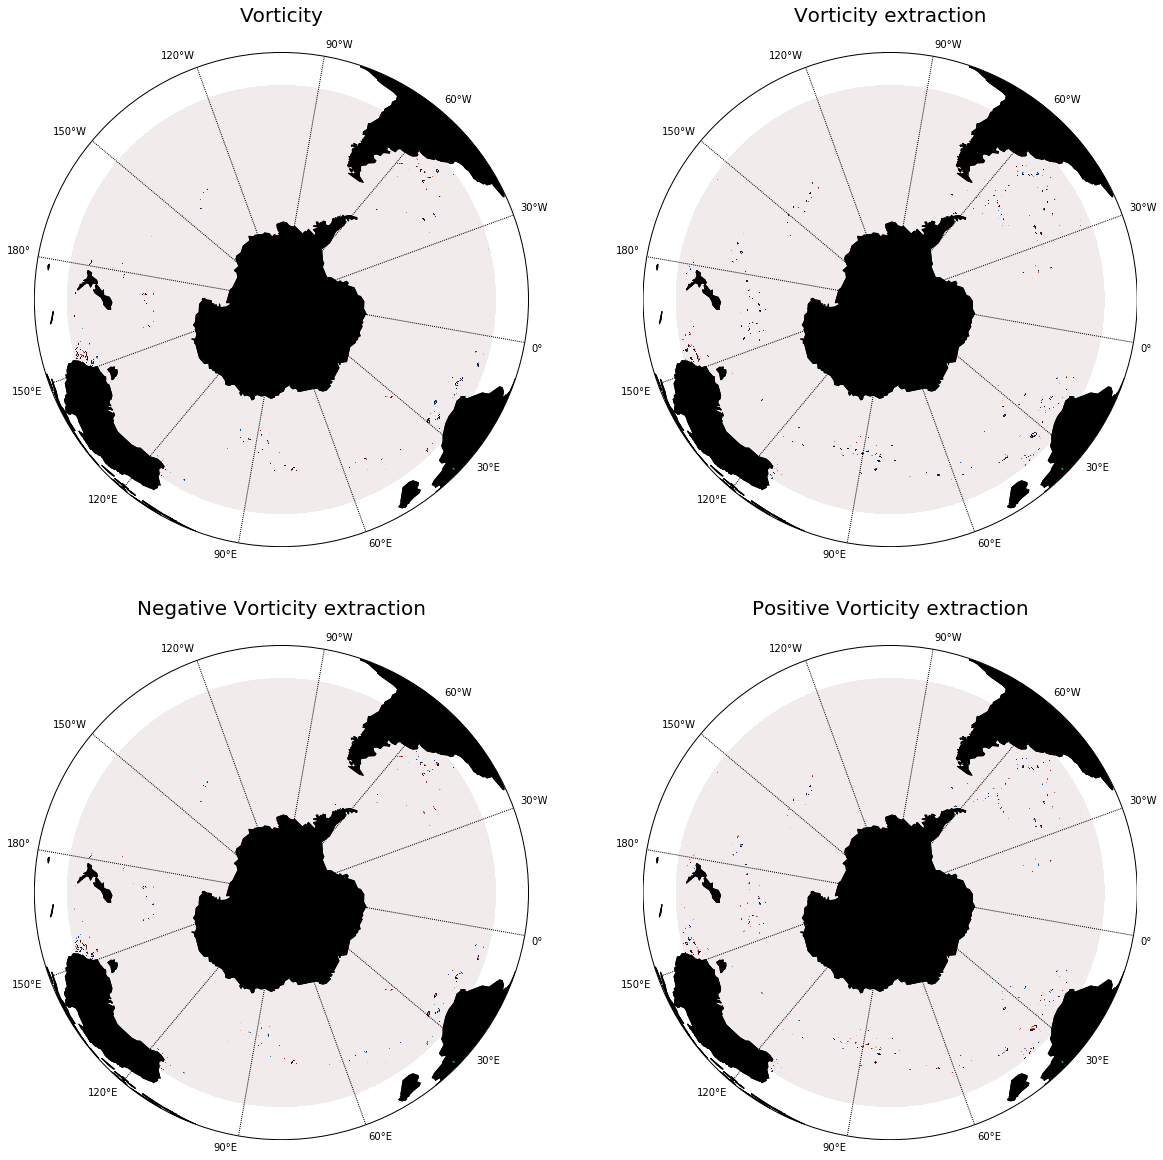

In [94]:
basemap_mplot(lon,lat,[eddysup,eddysun,eddysvp,eddysvn]\
              ,title=["Vorticity","Vorticity extraction","Negative Vorticity extraction",\
                       "Positive Vorticity extraction"],scale='Lin',cmap=cm.cm.balance,\
              vmin=-0.2,vmax=0.2,xan=2,yan=2,figsize=(20,20),fontsize=20);

# EKE

In [95]:
eddyu=(eddysun+eddysup)
eddyv=(eddysvn+eddysvp)

In [96]:
def KE(u,v):
    ke=(1/2)*(u**2+v**2)
    return ke

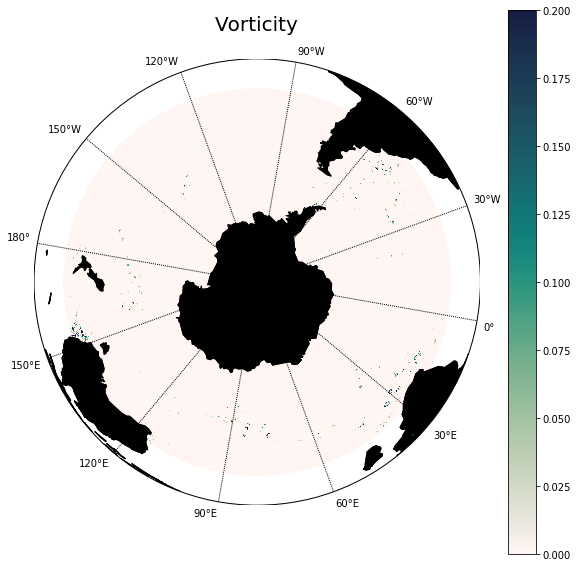

In [103]:
eke=KE(eddyu,eddyv)

basemap_mplot(lon,lat,eke,title="Vorticity",scale='Lin',cmap=cm.cm.tempo,\
              vmin=0,vmax=0.2,xan=1,yan=1,figsize=(10,10),fontsize=20);
colorbar()

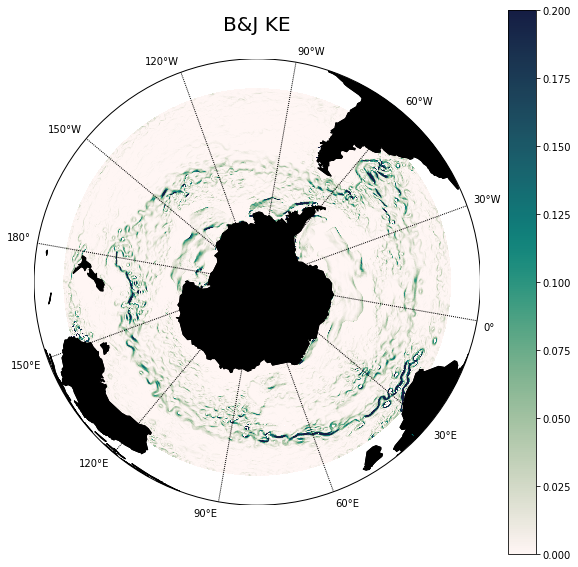

In [104]:
bjke=KE(u_g-eddyu,v_g-eddyv)
basemap_mplot(lon,lat,bjke,title="B&J KE",scale='Lin',cmap=cm.cm.tempo,\
              vmin=0,vmax=0.2,xan=1,yan=1,figsize=(10,10),fontsize=20);
colorbar()

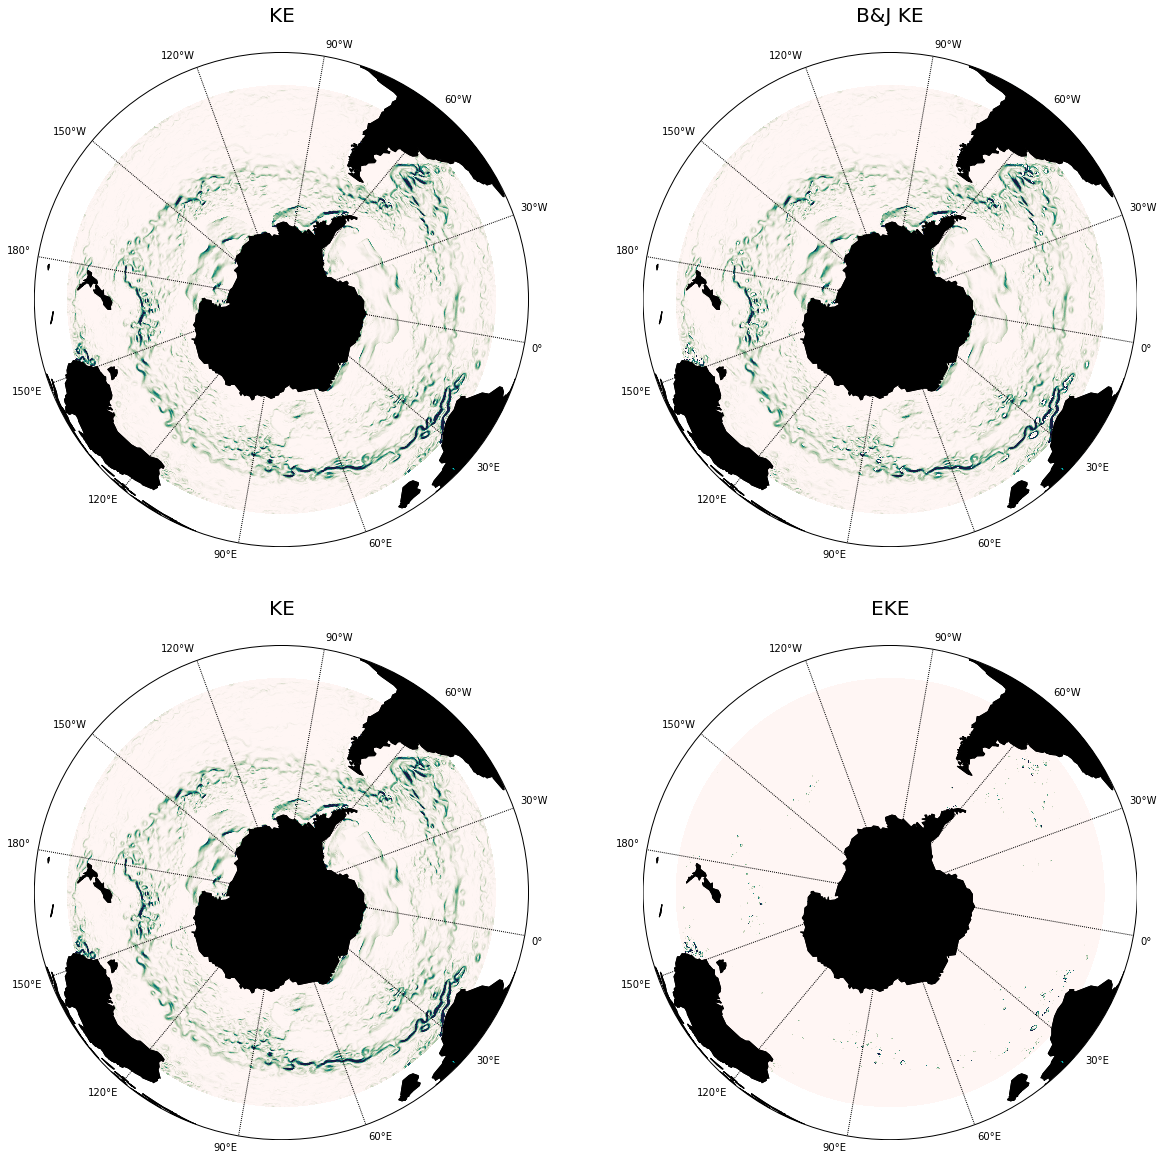

In [105]:
ke=KE(u_g,v_g)
basemap_mplot(lon,lat,[ke,bjke,ke,eke]\
              ,title=["KE","B&J KE","KE","EKE"],scale='Lin',cmap=cm.cm.tempo,\
              vmin=0,vmax=0.2,xan=2,yan=2,figsize=(20,20),fontsize=20);